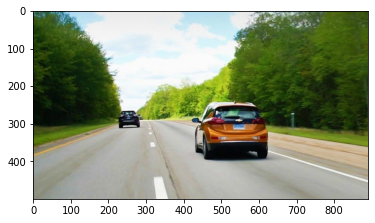

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import copy

raw_img = cv2.imread('../test/road.jpg') 
img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB)

plt.imshow(img)

In [3]:
class Node:
    def __init__(self, img, x, y, topLeft = None, topRight = None, bottomLeft = None, bottomRight = None):
        self.img = img
        self.x = x
        self.y = y
        if(topLeft == None):
            self.isLeaf = True
        else:
            self.isLeaf = False
        self.topLeft = topLeft
        self.topRight = topRight
        self.bottomLeft = bottomLeft
        self.bottomRight = bottomRight
    
    def isHomogenous(self, tolerance):
        if(self.img.shape[0] == 0 or self.img.shape[1] == 0):
            return True
        rgb = np.array([[[np.floor(np.mean(self.img[:,:,0])), np.floor(np.mean(self.img[:,:,1])), np.floor(np.mean(self.img[:,:,2]))]]], dtype = np.uint8)
        redMean = (self.img[:, :, 0] + rgb[:, :, 0])//2
        rgbDiff = np.square(self.img - rgb)
        distances = rgbDiff[:, :, 0] * (2 + redMean / 256) + rgbDiff[:, :, 1] * (4) + rgbDiff[:, :, 2] * (2 + (255 - redMean) / 256)
        distances = np.sqrt(distances) 
        mx = np.max(distances)
        mn = np.min(distances)
        if(mx - mn < tolerance):
            self.img[:, :] = rgb[0, 0]
            return True
        else:
            return False

    def isAdj(self, other):
        otherH = other.img.shape[0]
        otherW = other.img.shape[1]
        h = self.img.shape[0]
        w = self.img.shape[1]
        if other.x == self.x + h or other.x + otherH == self.x:
            return self.y - otherW <= other.y <= self.y + w
        if other.y == self.y + w or other.y + otherW == self.y:
            return self.x - otherH <= other.x <= self.x + h
        return False  

    def setChildren(self, topLeft, topRight, bottomLeft, bottomRight):
        self.topLeft = topLeft
        self.topRight = topRight
        self.bottomLeft = bottomLeft
        self.bottomRight = bottomRight
        

In [4]:
class Cluster:
    def __init__(self, first: Node):
        self.rgb = np.array([[first.img[0, 0]]], dtype=np.uint8)
        self.list = [first]
        self.dictbyX = {first.x: [0]}
        self.dictbyY = {first.y: [0]}
        self.dictbyXH = {first.x + first.img.shape[0]: [0]}
        self.dictbyYW = {first.y + first.img.shape[1]: [0]} 

    def isMember(self, elm: Node):
        found = False
        if elm.x + elm.img.shape[0] in self.dictbyX.keys():
            for member in [self.list[i] for i in self.dictbyX[elm.x+elm.img.shape[0]]]:
                if(elm.isAdj(member)):
                    found = True
                    break

        if not(found) and elm.y + elm.img.shape[1] in self.dictbyY.keys():
            for member in [self.list[i] for i in self.dictbyY[elm.y+elm.img.shape[1]]]:
                if(elm.isAdj(member)):
                    found = True
                    break

        if not(found) and elm.y in self.dictbyYW.keys():
            for member in [self.list[i] for i in self.dictbyYW[elm.y]]:
                if(elm.isAdj(member)):
                    found = True
                    break

        if not(found) and elm.x in self.dictbyXH.keys():
            for member in [self.list[i] for i in self.dictbyXH[elm.x]]:
                if(elm.isAdj(member)):
                    found = True
                    break

        if not(found): 
            return np.finfo(float).max

        redMean = (int(elm.img[0, 0, 0]) + int(self.rgb[0, 0, 0]))//2
        diffr = int(elm.img[0, 0, 0]) - int(self.rgb[0, 0, 0])
        diffg = int(elm.img[0, 0, 1]) - int(self.rgb[0, 0, 1])
        diffb = int(elm.img[0, 0, 2]) - int(self.rgb[0, 0, 2])

        return np.sqrt((((512+redMean)*diffr*diffr)>>8) + 4*diffg*diffg + (((767-redMean)*diffb*diffb)>>8)) 
        

    def appendElm(self, elm: Node):
        if elm.x in self.dictbyX.keys():
            self.dictbyX[elm.x].append(len(self.list))
        else:
            self.dictbyX[elm.x] = [len(self.list)]

        if elm.y in self.dictbyY.keys():
            self.dictbyY[elm.y].append(len(self.list))
        else:
            self.dictbyY[elm.y] = [len(self.list)]

        if elm.x + elm.img.shape[0] in self.dictbyXH.keys():
            self.dictbyXH[elm.x+elm.img.shape[0]].append(len(self.list))
        else:
            self.dictbyXH[elm.x+elm.img.shape[0]] = [len(self.list)]

        if elm.y + elm.img.shape[1] in self.dictbyYW.keys():
            self.dictbyYW[elm.y+elm.img.shape[1]].append(len(self.list))
        else:
            self.dictbyYW[elm.y+elm.img.shape[1]] = [len(self.list)]

        for i in range(3):
            self.rgb[0, 0, i] = (int(self.rgb[0, 0, i])*len(self.list) + int(elm.img[0, 0, i]))//(len(self.list)+1)
        self.list.append(elm)

    def colorizeAll(self):
        for elm in self.list:
            elm.img[:, :] = self.rgb[0, 0]

In [5]:
class Tree:
    def __init__(self, img, splitTolerance, mergeTolerance):
        tmp = copy.deepcopy(img)

        self.root = Node(tmp, 0, 0)
        self.nodeList = []
        self.clusterList = []

        self.constructTree(self.root, splitTolerance)
        self.splittedImg = copy.deepcopy(tmp)

        self.mergeTree(mergeTolerance)
        self.mergedImg = copy.deepcopy(tmp)
    
    
    def constructTree(self, parent: Node, tolerance):
        if(not(parent.isHomogenous(tolerance))):
            halfHeight = parent.img.shape[0]//2
            halfWidth = parent.img.shape[1]//2
            
            x = parent.x
            y = parent.y


            topLeft = Node(parent.img[:halfHeight, :halfWidth], x, y)
            topRight = Node(parent.img[:halfHeight, halfWidth:], x, y+halfWidth)
            bottomLeft = Node(parent.img[halfHeight:, :halfWidth], x+halfHeight, y)
            bottomRight = Node(parent.img[halfHeight:, halfWidth:], x+halfHeight, y+halfWidth)

            parent.setChildren(topLeft, topRight, bottomLeft, bottomRight)

            self.constructTree(topLeft, tolerance)
            self.constructTree(topRight, tolerance)
            self.constructTree(bottomLeft, tolerance)
            self.constructTree(bottomRight, tolerance)
        elif(parent.img.shape[0] !=0 and parent.img.shape[1] != 0):
            self.nodeList.append(parent)

    def mergeTree(self, tolerance):
        for elm in self.nodeList:
            if(len(self.clusterList)==0):
                self.clusterList.append(Cluster(elm))
            else:
                found = False
                for group in self.clusterList:
                    if group.isMember(elm) < tolerance:
                        group.appendElm(elm)
                        found = True
                if not(found):
                    self.clusterList.append(Cluster(elm))
        self.colorize()

    def colorize(self):
        for cluster in self.clusterList:
            cluster.colorizeAll()

    def showSplittedImg(self):
        plt.imshow(self.splittedImg)

    def showMergedImg(self):
        plt.imshow(self.mergedImg)


In [6]:
tree = Tree(img, 33, 85)

In [7]:
print(len(tree.nodeList))
print(len(tree.clusterList))

1807
176


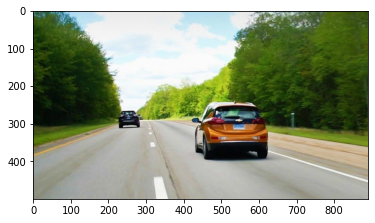

In [8]:
plt.imshow(img)

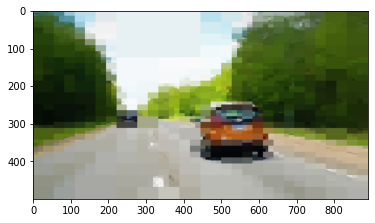

In [9]:
tree.showSplittedImg()

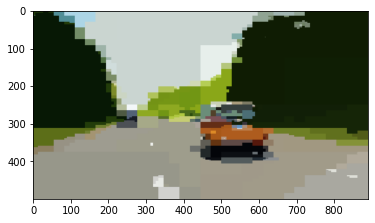

In [10]:
tree.showMergedImg()